# Capstone Project: Predicting additional tax revenue for the state of Connecticut if sports wagering is legalized

## Problem Statement

The State Legislature of Connecticut is reviewing a bill to legalize sports wagering within the state. The State Legislature must carefully weigh pros and cons when deciding pass or reject the bill. If they pass the bill, the bill moves on to the Sentate for final approval. If the Senate approves, Connecticut would become the 12th state in the United States where sports wagering has been legalized.

A major consideration by the State Legislature is the potential revenue gain in the State General fund. All sources of gaming share revenue with the state and make transfers into the State General fund at the end of the fiscal year. While sports wagering itsself is likely to bring in new revenue for the state, the state must consider reductions in other revenue streams that the new sports wagering revenue stream may cause. 

Using West Virginia has a protype, we will build a SARIMAX time series model that will predict tax revenue for one year, broken down on a weekly basis. After modeling, we will use mean squared error to measure the model's succes. Our goal is to provide the state with a model that can predict tax revenue as closely as possible, giving the state more confidence to make their decision.

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings 
import warnings
warnings.simplefilter(action="ignore")

np.random.seed(42)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('./data/wv_combined.csv')

## Cleaning / EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 10 columns):
week_ending                52 non-null object
tickets_written            52 non-null int64
 voids                     52 non-null int64
tickets_cashed             52 non-null int64
mobile_taxable_receipts    31 non-null float64
retail_taxable_receipts    52 non-null int64
total_taxable_receipts     52 non-null int64
privilege_tax              52 non-null int64
admin_share                52 non-null int64
state_share                52 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 4.2+ KB


In [5]:
df.columns

Index(['week_ending', 'tickets_written', ' voids  ', 'tickets_cashed',
       'mobile_taxable_receipts', 'retail_taxable_receipts',
       'total_taxable_receipts', 'privilege_tax', 'admin_share',
       'state_share'],
      dtype='object')

In [6]:
df.shape

(52, 10)

In [7]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,52.000,52.000,52.000,31.000,52.000,52.000,52.000,52.000,52.000
mean,3260718.269,70093.481,3912400.519,170215.161,266680.423,368154.865,36815.481,5522.308,31293.192
std,1103890.972,30709.032,2228876.644,221671.646,374279.472,501747.822,50174.777,7526.214,42648.612
min,1110150.000,19058.000,1181917.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2202031.000,46195.000,1954432.500,35048.000,126691.250,154329.250,15433.250,2315.000,13118.250
50%,3702858.000,67988.000,3563424.000,149607.000,244725.000,295824.500,29582.500,4437.000,25145.000
75%,4164717.750,91458.250,5706824.000,276460.000,417141.500,681037.000,68103.750,10215.500,57888.250
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [8]:
df.dtypes

week_ending                 object
tickets_written              int64
 voids                       int64
tickets_cashed               int64
mobile_taxable_receipts    float64
retail_taxable_receipts      int64
total_taxable_receipts       int64
privilege_tax                int64
admin_share                  int64
state_share                  int64
dtype: object

In [9]:
df['week_ending'] = pd.to_datetime(df['week_ending'])

In [10]:
df.dtypes

week_ending                datetime64[ns]
tickets_written                     int64
 voids                              int64
tickets_cashed                      int64
mobile_taxable_receipts           float64
retail_taxable_receipts             int64
total_taxable_receipts              int64
privilege_tax                       int64
admin_share                         int64
state_share                         int64
dtype: object

In [11]:
df.describe()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
count,52.000,52.000,52.000,31.000,52.000,52.000,52.000,52.000,52.000
mean,3260718.269,70093.481,3912400.519,170215.161,266680.423,368154.865,36815.481,5522.308,31293.192
std,1103890.972,30709.032,2228876.644,221671.646,374279.472,501747.822,50174.777,7526.214,42648.612
min,1110150.000,19058.000,1181917.000,-571570.000,-844841.000,-1416411.000,-141641.000,-21246.000,-120395.000
25%,2202031.000,46195.000,1954432.500,35048.000,126691.250,154329.250,15433.250,2315.000,13118.250
50%,3702858.000,67988.000,3563424.000,149607.000,244725.000,295824.500,29582.500,4437.000,25145.000
75%,4164717.750,91458.250,5706824.000,276460.000,417141.500,681037.000,68103.750,10215.500,57888.250
max,4902465.000,154935.000,9404206.000,601782.000,1388791.000,1664244.000,166424.000,24964.000,141461.000


In [12]:
test = ' voids '
test.strip()

'voids'

In [13]:
df.columns = [col.strip() for col in df.columns]

In [14]:
df.isnull().sum().sort_values(ascending = False)

mobile_taxable_receipts    21
state_share                 0
admin_share                 0
privilege_tax               0
total_taxable_receipts      0
retail_taxable_receipts     0
tickets_cashed              0
voids                       0
tickets_written             0
week_ending                 0
dtype: int64

In [15]:
df[df.isna().any(axis=1)]

,week_ending,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
10,2019-03-16,2858410,70218,2565896,nan,222296,222296,22230,3334,18895
11,2019-03-23,4418971,91090,3554777,nan,773104,773104,77310,11597,65714
12,2019-03-30,3443807,67494,3025699,nan,350615,350615,35061,5259,29802
13,2019-04-06,2385379,68355,2123295,nan,193729,193729,19373,2906,16467
16,2019-04-27,2607302,49943,2587349,nan,-29989,-29989,-2999,-450,-2549
17,2019-05-04,2296202,38167,1856748,nan,401287,401287,40129,6019,34109
18,2019-05-11,2210385,30720,2190474,nan,-10808,-10808,-1081,-162,-919
19,2019-05-18,2176969,44266,1975717,nan,156986,156986,15699,2355,13344
20,2019-05-25,1984382,31461,1885233,nan,67688,67688,6769,1015,5754
21,2019-06-01,2036091,22197,1691982,nan,321912,321912,32191,4829,27363


In [16]:
df.fillna(0, inplace=True)

In [17]:
df.isnull().sum().sort_values(ascending = False)

state_share                0
admin_share                0
privilege_tax              0
total_taxable_receipts     0
retail_taxable_receipts    0
mobile_taxable_receipts    0
tickets_cashed             0
voids                      0
tickets_written            0
week_ending                0
dtype: int64

### Visualizing (this won't be an actual section)

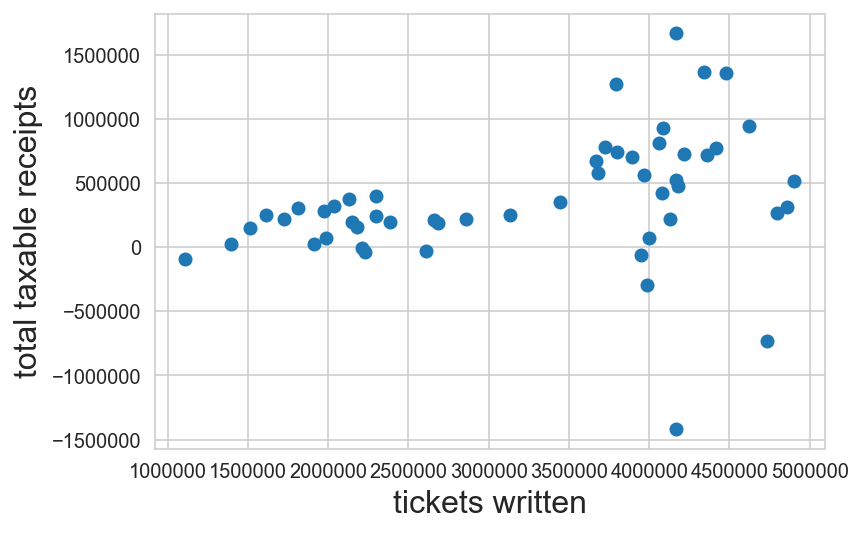

In [18]:
plt.scatter(df["tickets_written"], df["total_taxable_receipts"])
plt.xlabel("tickets written", fontsize = 16)
plt.ylabel("total taxable receipts", fontsize = 16);

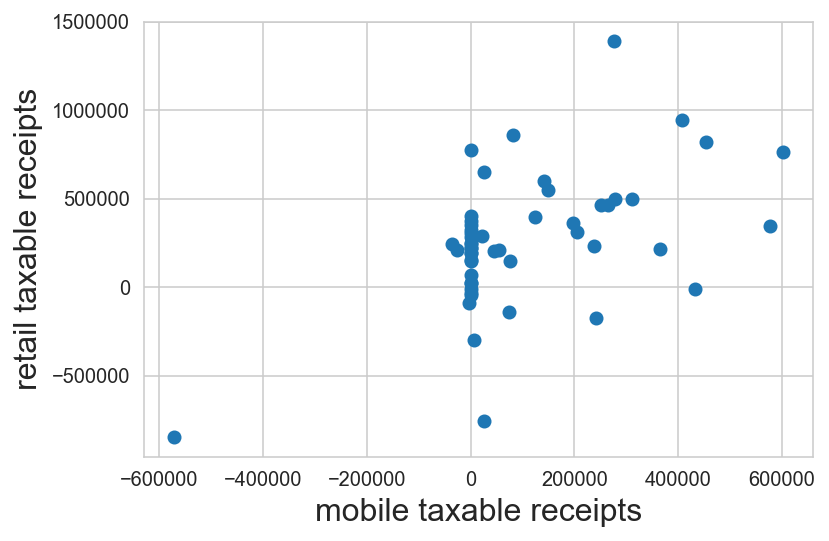

In [19]:
plt.scatter(df['mobile_taxable_receipts'], df['retail_taxable_receipts'])
plt.xlabel("mobile taxable receipts", fontsize = 16)
plt.ylabel("retail taxable receipts", fontsize = 16);

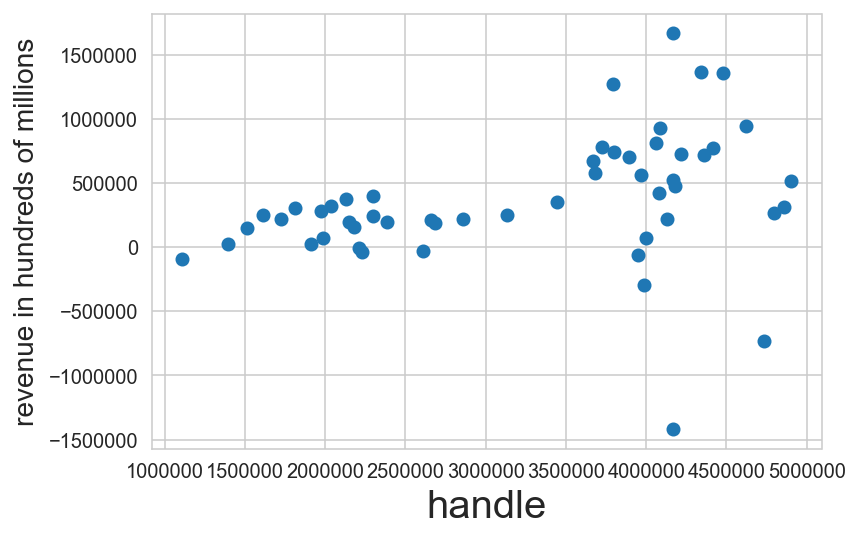

In [20]:
plt.scatter(df['tickets_written'], df['total_taxable_receipts'])
plt.xlabel('handle', fontsize = 20)
plt.ylabel('revenue in hundreds of millions', fontsize = 14);

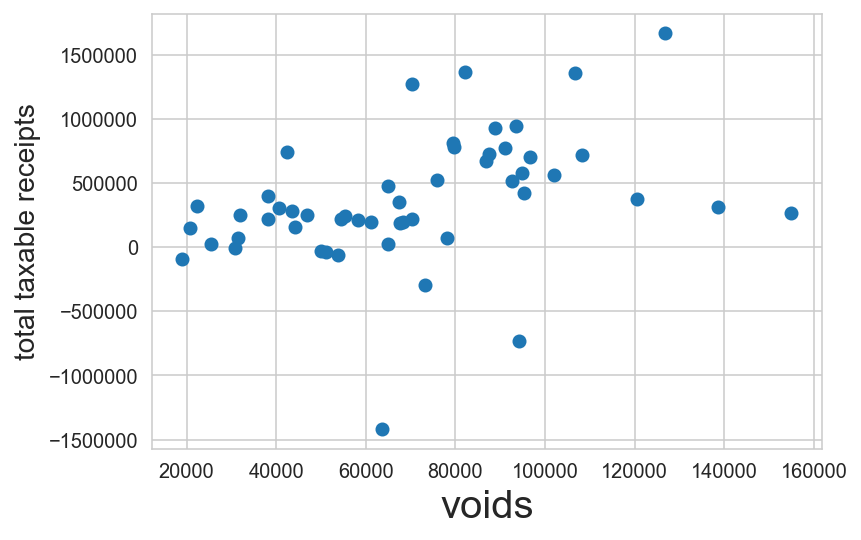

In [21]:
plt.scatter(df['voids'], df['total_taxable_receipts'])
plt.xlabel('voids', fontsize = 20)
plt.ylabel('total taxable receipts', fontsize = 14);

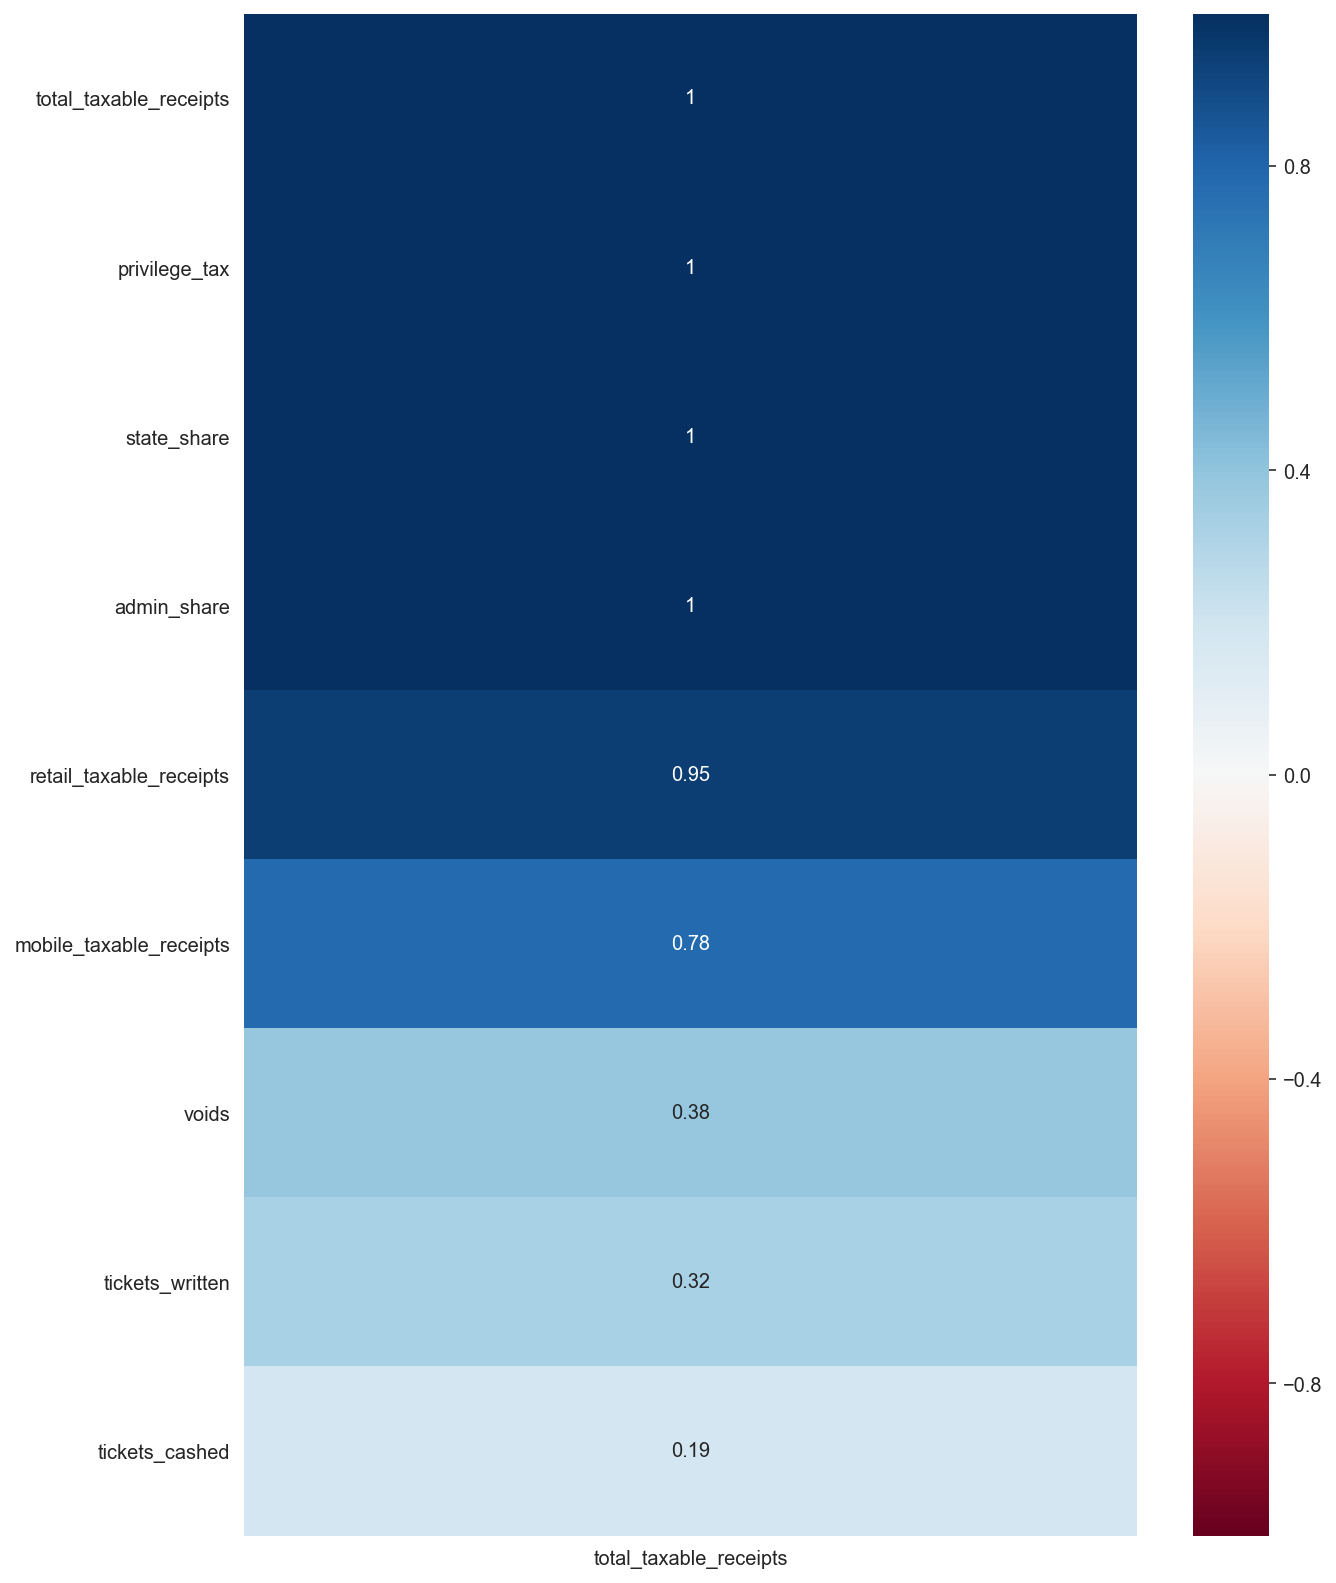

In [22]:
# Heatmap of the corrleations of features and revenue
plt.figure(figsize = (10,14))
sns.heatmap(df.corr()[["total_taxable_receipts"]].sort_values(by = 'total_taxable_receipts', ascending = False),
                            annot = True,
                            cmap="RdBu",
                            vmin = -1,
                            vmax = 1);

### Preprocessing

In [23]:
df.set_index('week_ending', inplace=True)

In [24]:
total_taxable_receipts = pd.DataFrame(df['total_taxable_receipts'].groupby(df.index).sum())

In [46]:
df[['total_taxable_receipts']].head()

,total_taxable_receipts
week_ending,
2019-01-05,264445
2019-01-12,310758
2019-01-19,519831
2019-01-26,-292867
2019-02-02,944066


In [25]:
total_taxable_receipts.head()

,total_taxable_receipts
week_ending,
2019-01-05,264445
2019-01-12,310758
2019-01-19,519831
2019-01-26,-292867
2019-02-02,944066


## Time Series EDA (will move up to EDA section)


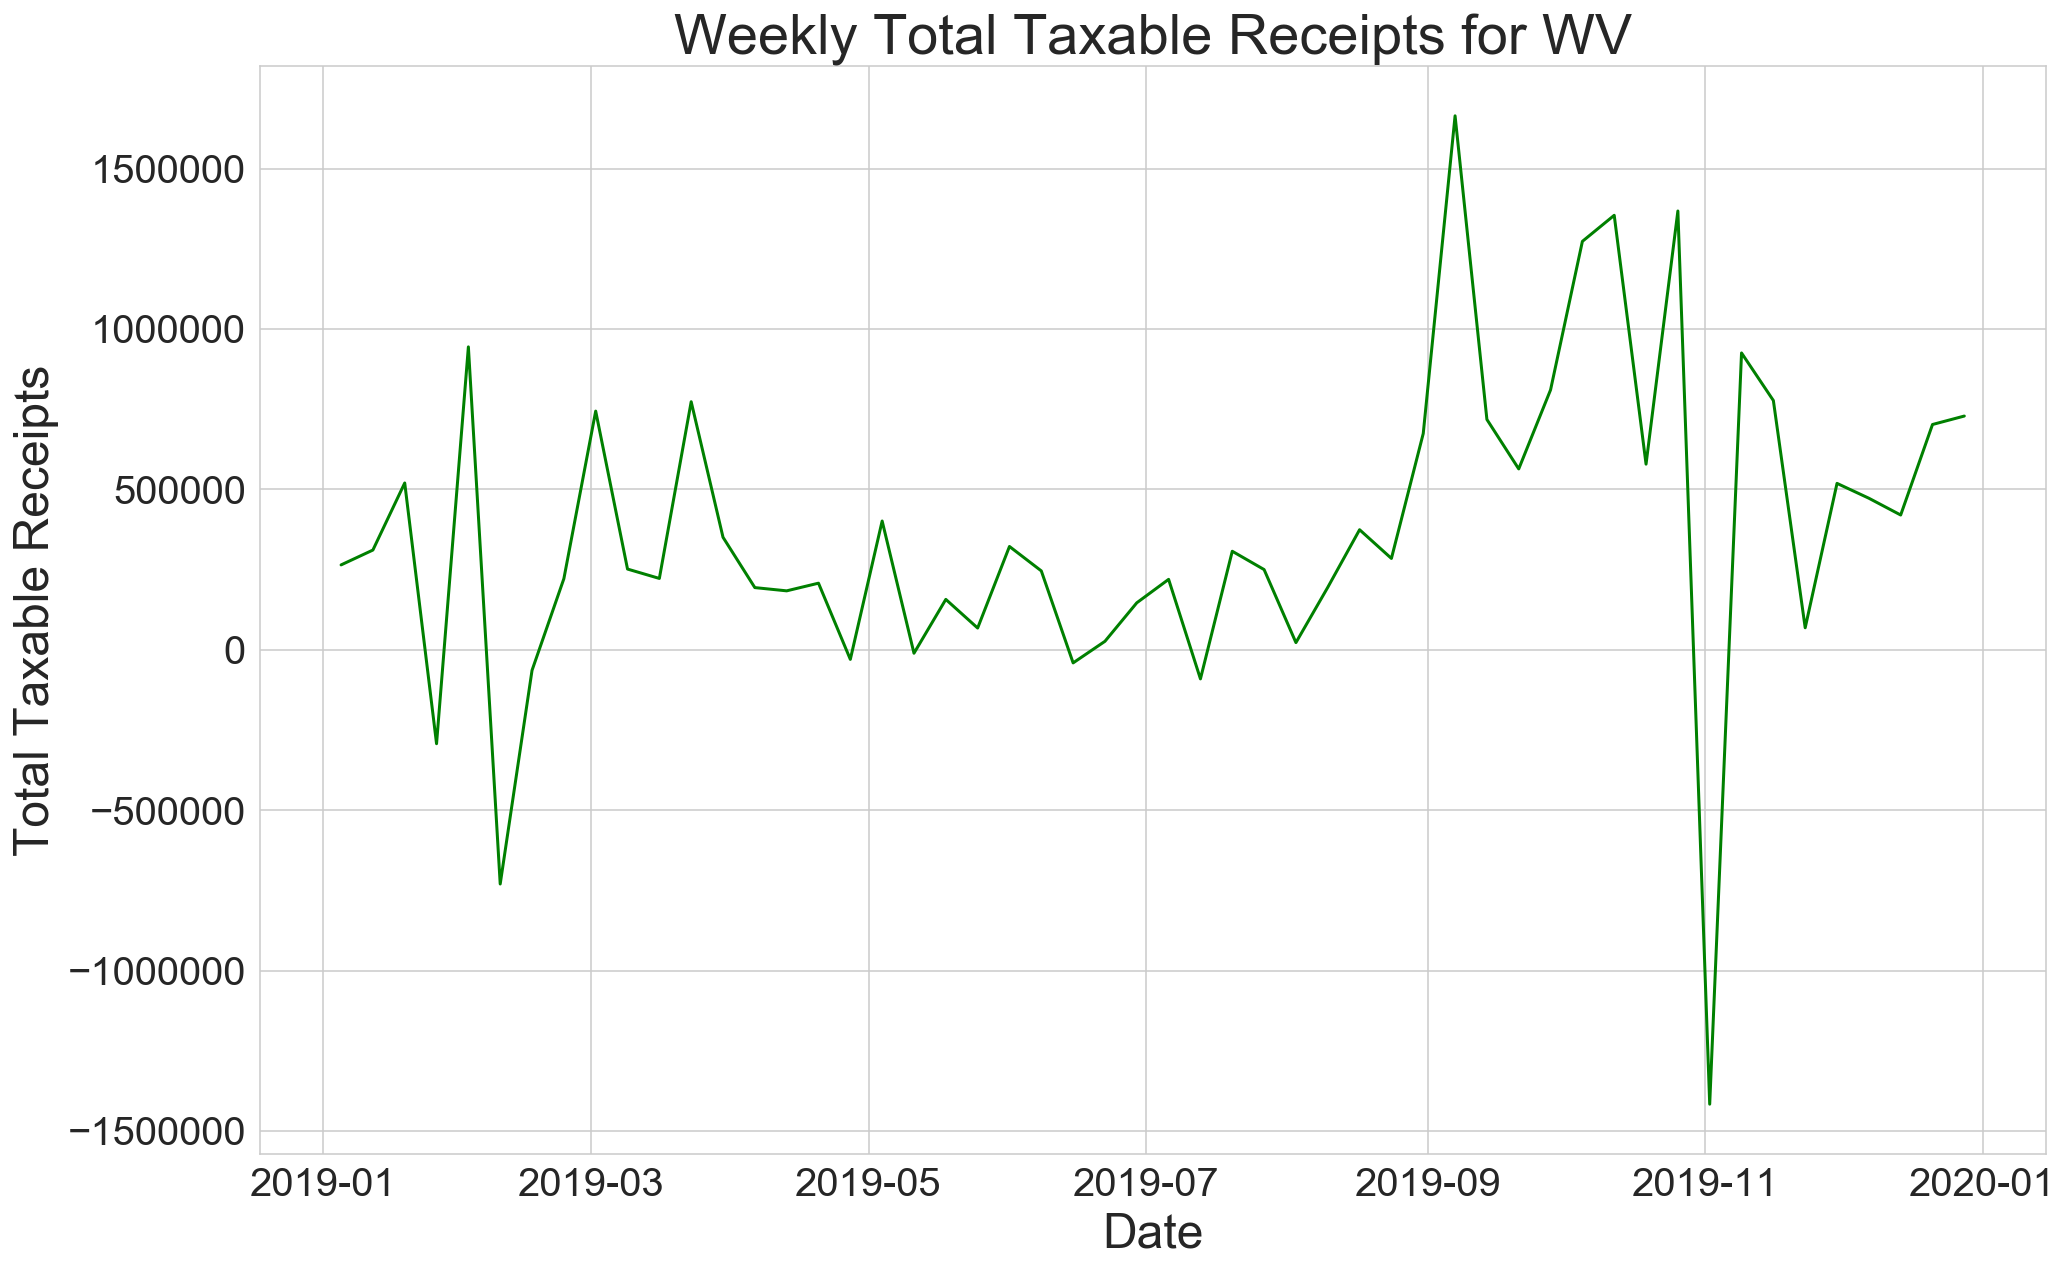

In [26]:
# Set figure size
plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(total_taxable_receipts, c ='green')

# Set labels and title.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Total Taxable Receipts', fontsize=24)
plt.title('Weekly Total Taxable Receipts for WV', fontsize=28);

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time.

In [27]:
# Calculating rolling means for Total Taxable Receipts

rolling_mean_1  = total_taxable_receipts.rolling(window = 1).mean()
rolling_mean_4 = total_taxable_receipts.rolling(window = 4).mean()
rolling_mean_13 = total_taxable_receipts.rolling(window = 13).mean()

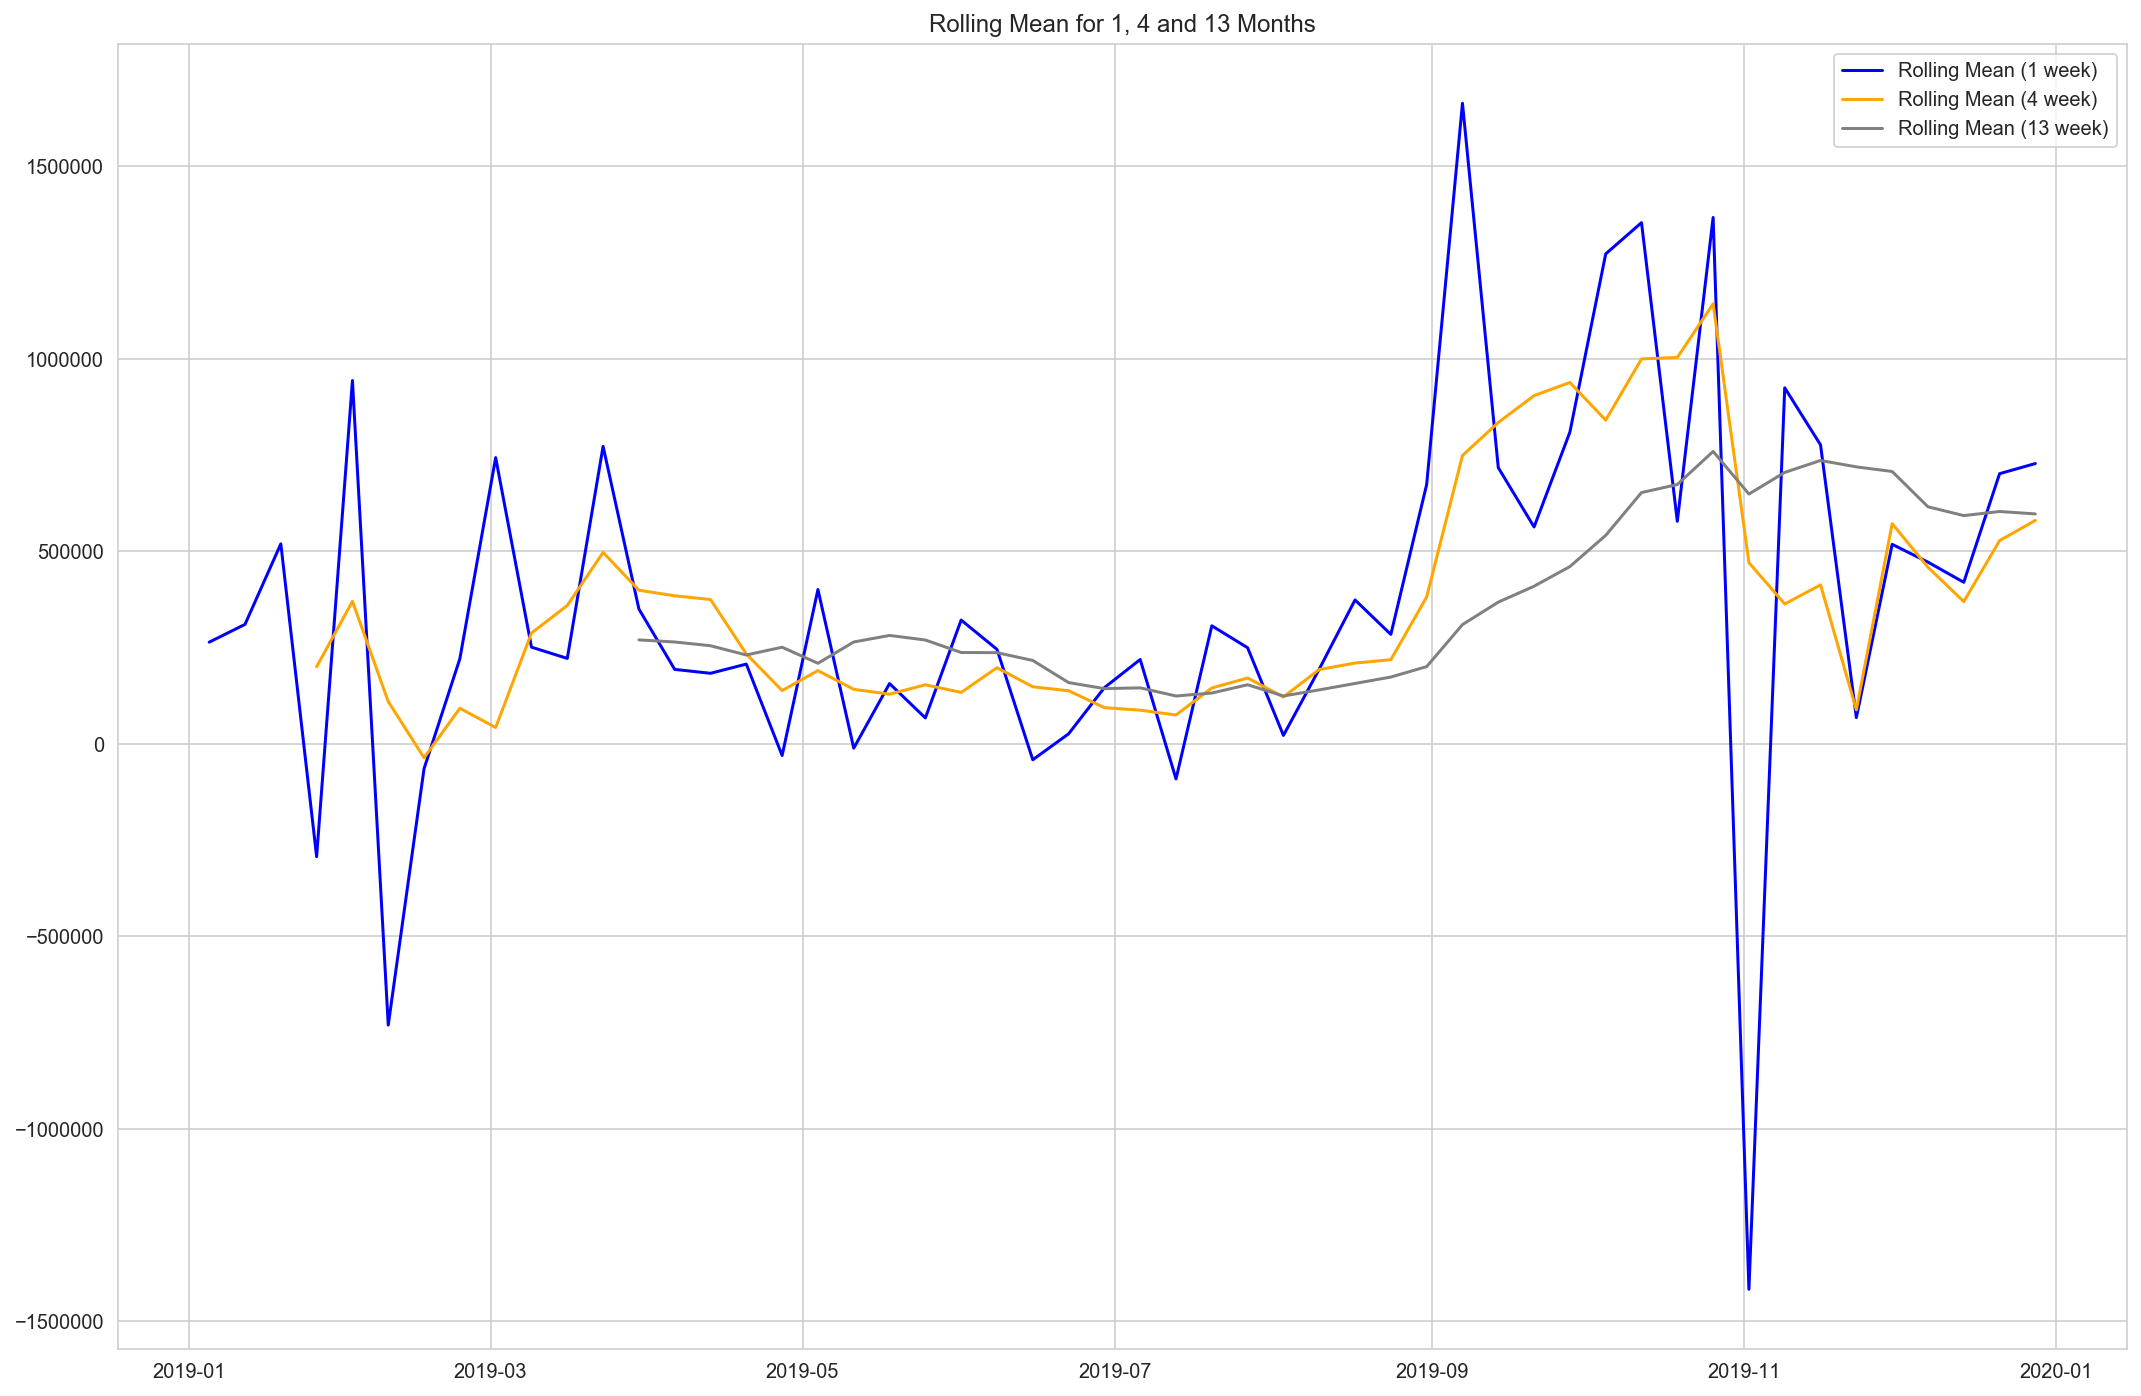

In [28]:
# Plot
plt.figure(figsize=(18,12))
plt.plot(rolling_mean_1, color='blue', label='Rolling Mean (1 week)')
plt.plot(rolling_mean_4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolling_mean_13, color='grey', label='Rolling Mean (13 week)')

plt.legend(loc='best')

plt.title('Rolling Mean for 1, 4 and 13 Months')
plt.show();

In [29]:
# Add interpretation 

In [48]:
# Relationship between Total Taxable Receipts and 1-lag Total Taxable Receipts
df["total_taxable_receipts"].autocorr(lag=1)

0.013471643479216042

In [49]:
# Relationship between Total Taxable Receipts and 4-lag Total Taxable Receipts
df["total_taxable_receipts"].autocorr(lag=2)

0.22298534166950224

In [50]:
# Relationship between Total Taxable Receipts and 26-lag Total Taxable Receipts
df["total_taxable_receipts"].autocorr(lag=26)

-0.1023072690809313

In [54]:
df["total_taxable_receipts"].autocorr(lag=50)

1.0

In [42]:
len(total_taxable_receipts)

52

In [33]:
# Add interpretation

#### ACF and PCF

In [57]:
df

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-01-05,4796300,154935,4376920,54089.000,210356,264445,26445,3967,22478
2019-01-12,4860953,138666,4411529,21356.000,289402,310758,31076,4661,26414
2019-01-19,4167883,75981,3572071,122956.000,396875,519831,51983,7797,44186
2019-01-26,3983320,73280,4202907,6185.000,-299052,-292867,-29287,-4393,-24894
2019-02-02,4622730,93425,3585239,81104.000,862961,944066,94407,14161,80246
2019-02-09,4731513,94134,5367534,25537.000,-755693,-730156,-73016,-10952,-62063
2019-02-16,3948434,53754,3958768,73298.000,-137385,-64087,-6409,-961,-5447
2019-02-23,4132014,54404,3856157,75005.000,146448,221454,22145,3322,18824
2019-03-02,3797635,42463,3011294,140722.000,603157,743879,74388,11158,63230


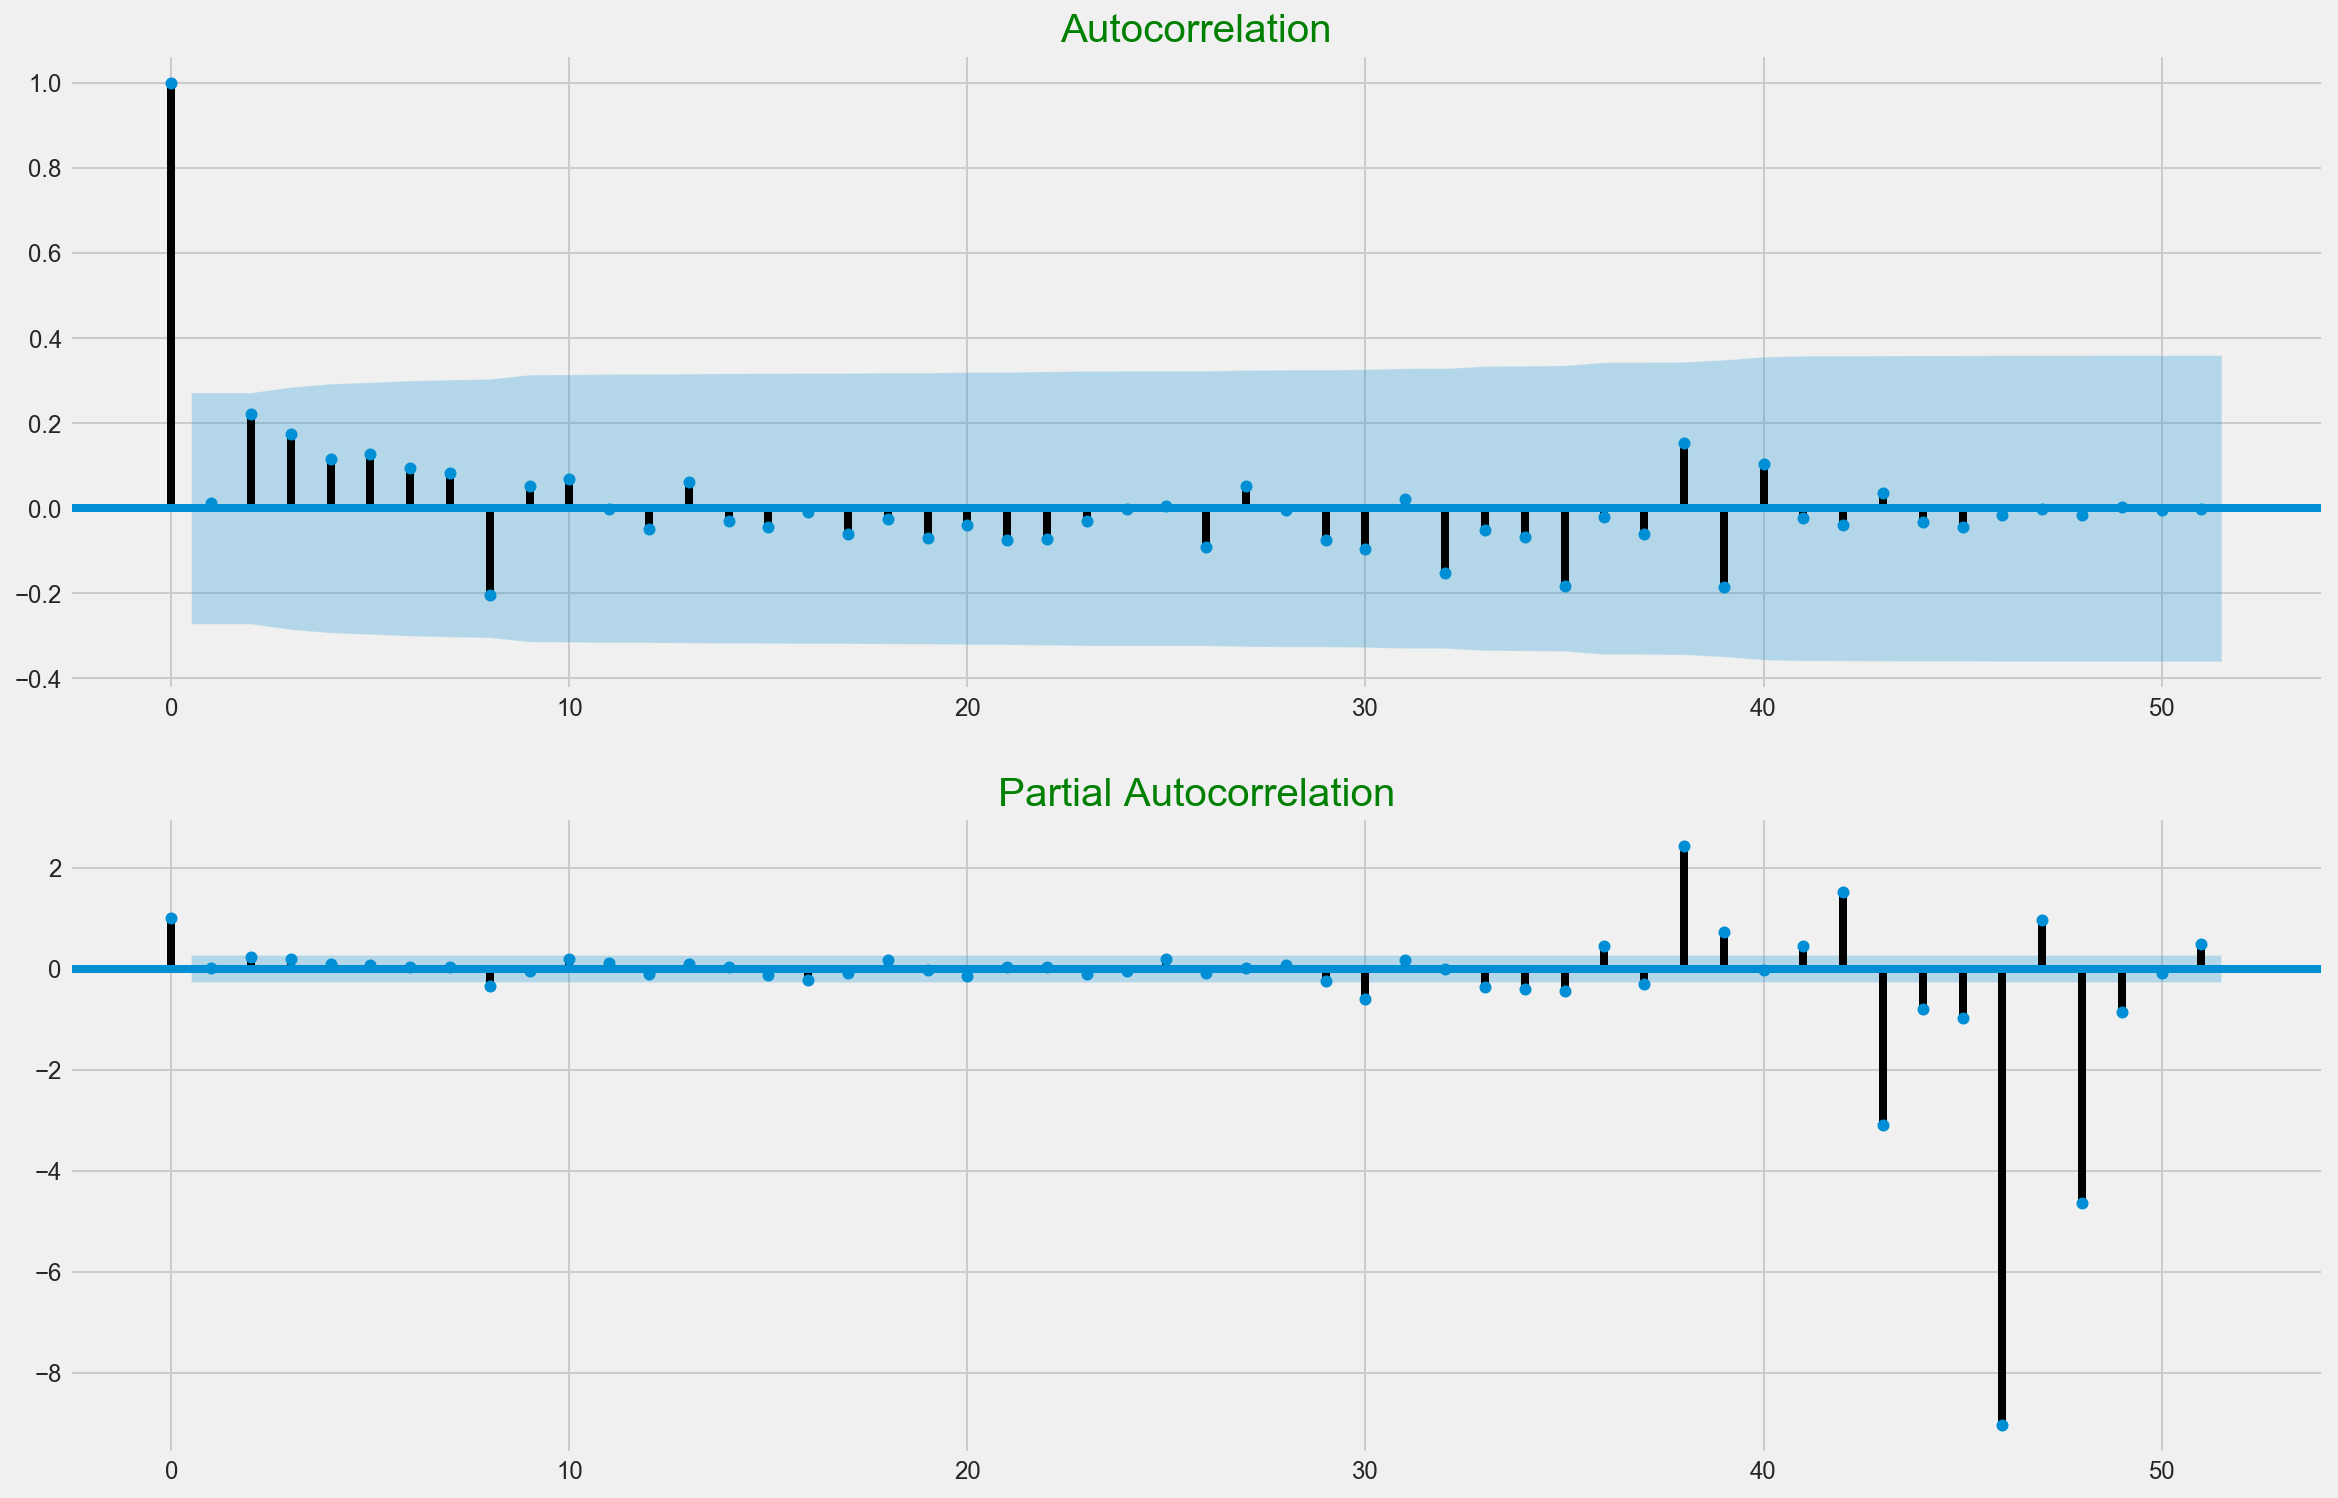

In [176]:
# 51-week ACF AND PCF

fig = plt.figure(figsize=(18,12))

ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(total_taxable_receipts, lags=51, ax=ax1)

ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(total_taxable_receipts, lags=51, ax=ax2);

In [105]:
# Add interpretation

## Preprocessing

#### Train-Test-Split

In [58]:
# Using a 75-25 split, our training set will be 39 rows and our test will be 13 rows

train = df.iloc[:40,]
test = df.iloc[40:,]

In [59]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='pink')
    plt.plot(test, c='blue');

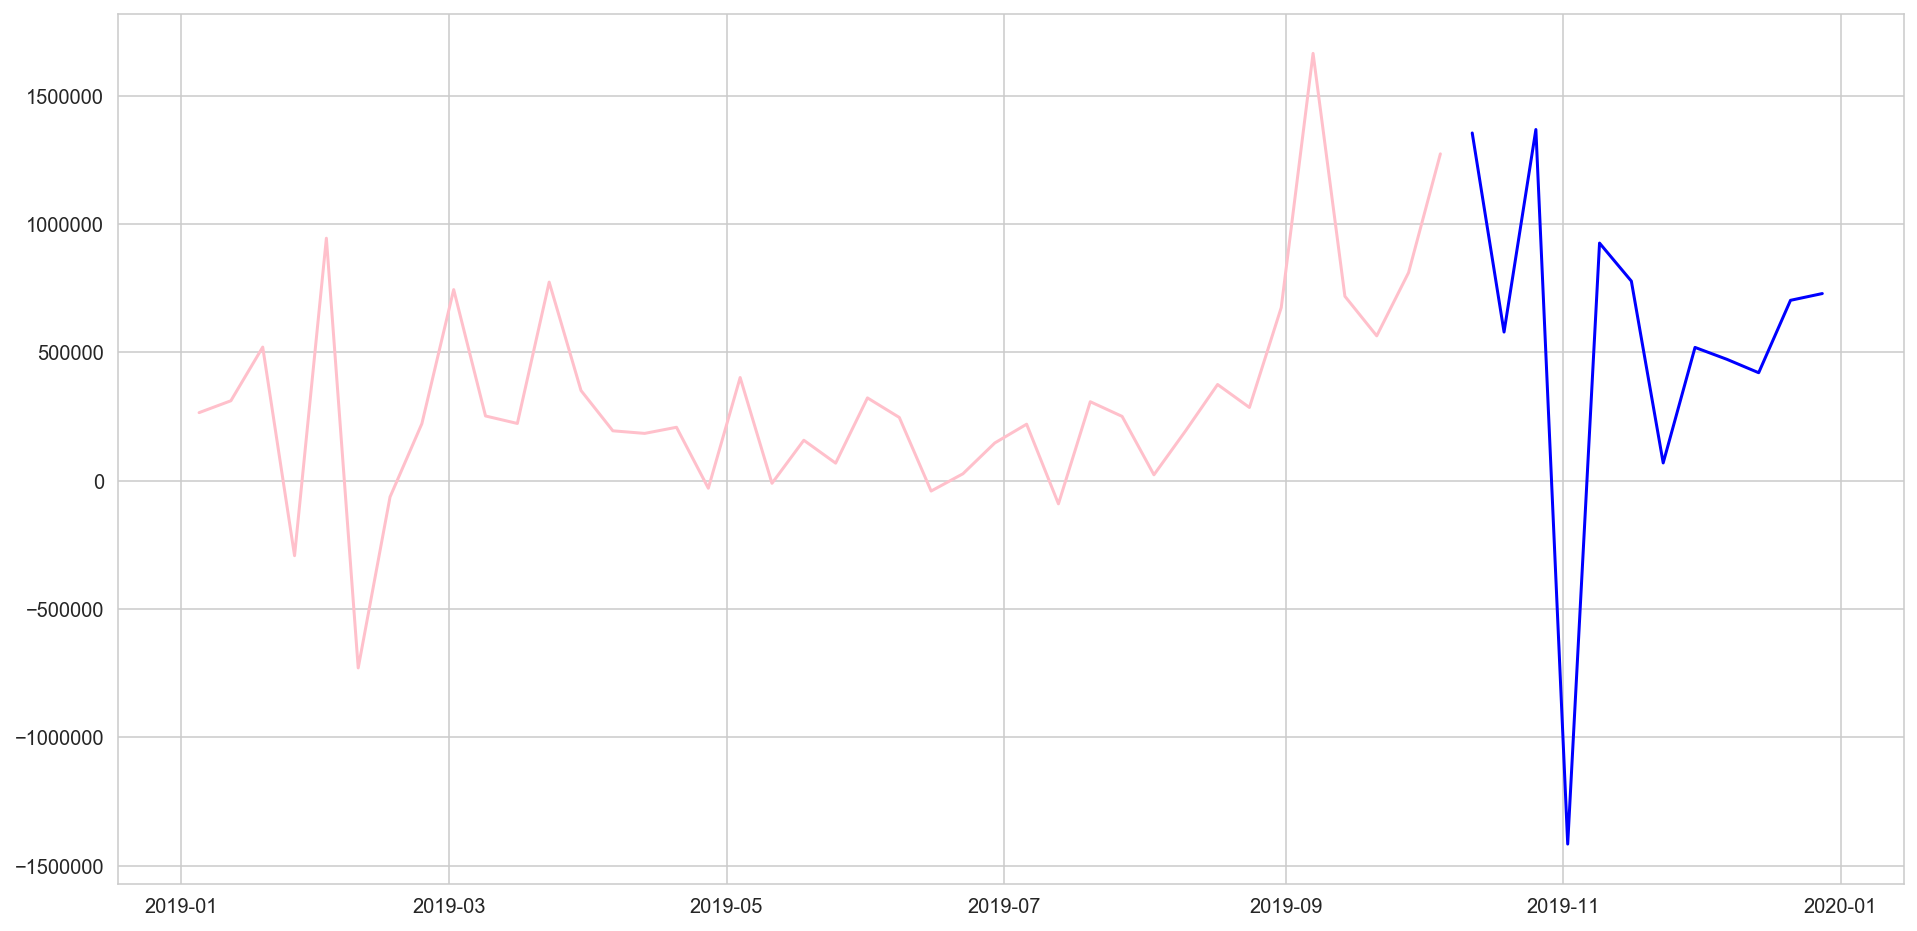

In [61]:
train_test_plot(train[['total_taxable_receipts']], test[['total_taxable_receipts']])

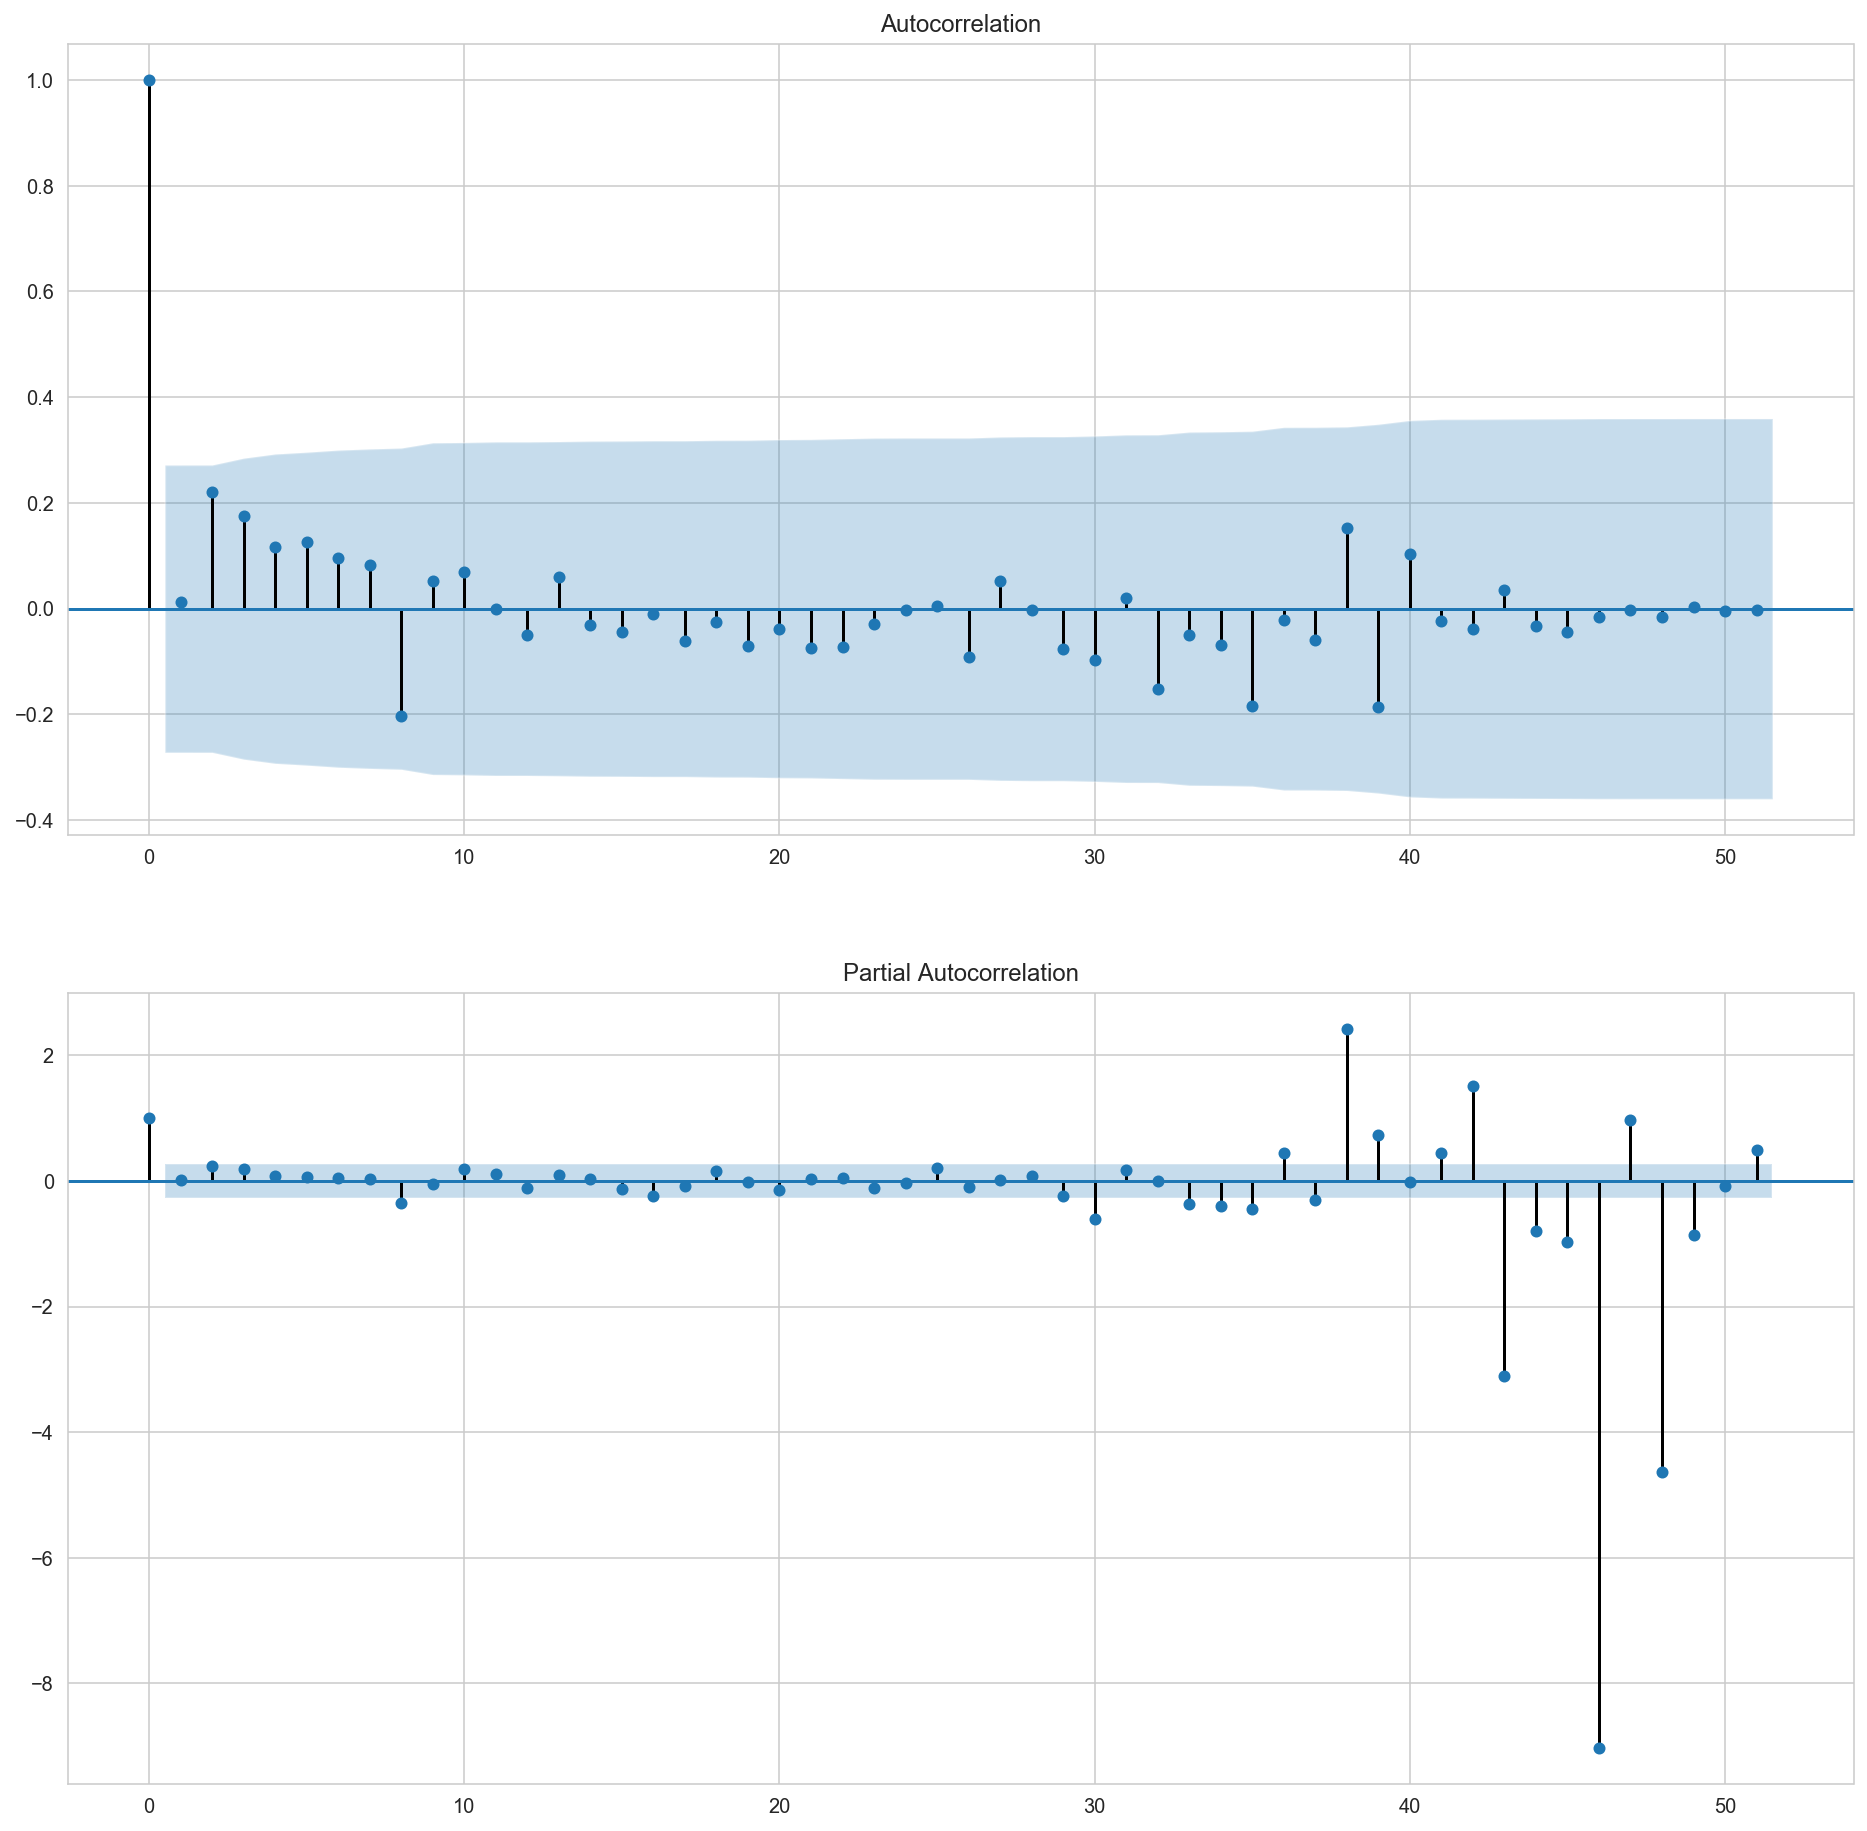

In [65]:

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(df[['total_taxable_receipts']], lags=51, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df[['total_taxable_receipts']], lags=51, ax=ax2)
plt.show();

In [66]:
train.head()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-01-05,4796300,154935,4376920,54089.000,210356,264445,26445,3967,22478
2019-01-12,4860953,138666,4411529,21356.000,289402,310758,31076,4661,26414
2019-01-19,4167883,75981,3572071,122956.000,396875,519831,51983,7797,44186
2019-01-26,3983320,73280,4202907,6185.000,-299052,-292867,-29287,-4393,-24894
2019-02-02,4622730,93425,3585239,81104.000,862961,944066,94407,14161,80246


In [67]:
test.head()

,tickets_written,voids,tickets_cashed,mobile_taxable_receipts,retail_taxable_receipts,total_taxable_receipts,privilege_tax,admin_share,state_share
week_ending,,,,,,,,,
2019-10-12,4478463,106603,6294572,406581.000,947614,1354195,135419,20313,115107
2019-10-19,3680379,94887,6082278,364190.000,214308,578497,57850,8677,49172
2019-10-26,4341311,82103,6399568,601782.000,765826,1367608,136761,20514,116247
2019-11-02,4165581,63569,9404206,-571570.000,-844841,-1416411,-141641,-21246,-120395
2019-11-09,4088691,88871,7335286,576236.000,348871,925107,92511,13877,78634


In [165]:
old_score = 1000000000000000000000


for p in range(3):
    for d in range(2):
        for q in range(3):
                ## instantiate sarima
                model = SARIMAX(endog = train['total_taxable_receipts'],
                                exog = train[['tickets_written', 'voids']],
                                order = (p,d,q),
                                seasonal_order = (0,0,0,0)).fit()
                ## predict
                
                y_hat = model.predict(start = test.index[0], 
                          end = test.index[-1],
                          exog = test[['tickets_written', 'voids']])
                
                ## score
                saved_score = mean_squared_error(test['total_taxable_receipts'].values, y_hat)**.5
                
                ## print score & params
                print(f'P,D,Q values: ({p,d,q}), Root Mean Squared Error: {saved_score}')
                if saved_score < old_score:
                    old_score = saved_score
                    best_params = (p,d,q)
print(f'Best RMSE achieved: {old_score} with these p,d,q values: {best_params}')
                
                
#                 saved_model = (p,d,q,s)
#                 saved_score = mean_squared_error(test['total_taxable_receipts'].values, y_hat)**.5
#                 new_score = 1000000000000000000000
                
#                 if new_score < saved_score:
#                     saved_score.append(new_score)
                    
                    
                    
# for b in saved_score:
#     print(b)

# for m in best_model:
#     print(m)
                
                

                    
                
                
                
                
                ## instantiate sarima
                ## predict
                ## score
                ## print score & params
                
                ## Idea: maybe save score, and if score is lower than
                ##     previous best score, save current score as best
                
                
                # create a set of sarima configs to try

  

P,D,Q values: ((0, 0, 0)), Root Mean Squared Error: 673483.0205334281
P,D,Q values: ((0, 0, 1)), Root Mean Squared Error: 667225.076936715
P,D,Q values: ((0, 0, 2)), Root Mean Squared Error: 663370.5729713754
P,D,Q values: ((0, 1, 0)), Root Mean Squared Error: 1066851.7770107265
P,D,Q values: ((0, 1, 1)), Root Mean Squared Error: 749649.0047628373
P,D,Q values: ((0, 1, 2)), Root Mean Squared Error: 767938.7114808777
P,D,Q values: ((1, 0, 0)), Root Mean Squared Error: 665858.6789678294
P,D,Q values: ((1, 0, 1)), Root Mean Squared Error: 739505.2550290797
P,D,Q values: ((1, 0, 2)), Root Mean Squared Error: 677071.4807066517
P,D,Q values: ((1, 1, 0)), Root Mean Squared Error: 931039.6593838688
P,D,Q values: ((1, 1, 1)), Root Mean Squared Error: 771060.0505427652
P,D,Q values: ((1, 1, 2)), Root Mean Squared Error: 767245.0437204007
P,D,Q values: ((2, 0, 0)), Root Mean Squared Error: 675548.3052874246
P,D,Q values: ((2, 0, 1)), Root Mean Squared Error: 768936.6732635977
P,D,Q values: ((2, 0

In [193]:
## 1. What are 1 to 2 exogenous features you want to include (start small)
## 2. Since you only have 1 year of data, seasonality of order 50-52 doesn't make sense,
##    try smaller values

sarima = SARIMAX(endog = train['total_taxable_receipts'],
                 exog = train[['tickets_written', 'voids']],
                 order = (0,0,2),
                 seasonal_order = (0,0,0,0)).fit()

In [194]:
# Use this if we don't include exongenous features

#yhat = model_fit.forecast()

In [195]:
# Use this if we include exongenous features
y_hat = sarima.predict(start = test.index[0], 
                          end = test.index[-1],
                          #exog = test[['tickets_written', 'voids']])

In [207]:
y_hat

2019-10-12   655655.383
2019-10-19   576385.478
2019-10-26   465475.306
2019-11-02   418510.921
2019-11-09   459735.790
2019-11-16   416379.892
2019-11-23   433355.872
2019-11-30   525360.163
2019-12-07   421958.188
2019-12-14   470823.825
2019-12-21   459984.966
2019-12-28   466674.296
Freq: W-SAT, dtype: float64

In [197]:
mean_squared_error(test['total_taxable_receipts'].values, y_hat)**.5

663370.5729713754

In [200]:
train_mean = train['total_taxable_receipts'].mean()

In [203]:
baseline_preds = [train_mean for i in test['total_taxable_receipts']]

In [204]:
mean_squared_error(test['total_taxable_receipts'].values, baseline_preds)**0.5

724164.1823981728

In [ ]:
# https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/


In [ ]:
# Alter this to use it for weekly data! ^^^

Model configurations and the RMSE are printed as the models are evaluated The top three model configurations and their error are reported at the end of the run.

We can see that the best result was an RMSE of about 1,551 sales with the following configuration:

Trend Order: (0, 0, 0)
Seasonal Order: (1, 1, 0, 12)
Trend Parameter: ‘t’ (linear trend)

In [129]:
from pylab import rcParams
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

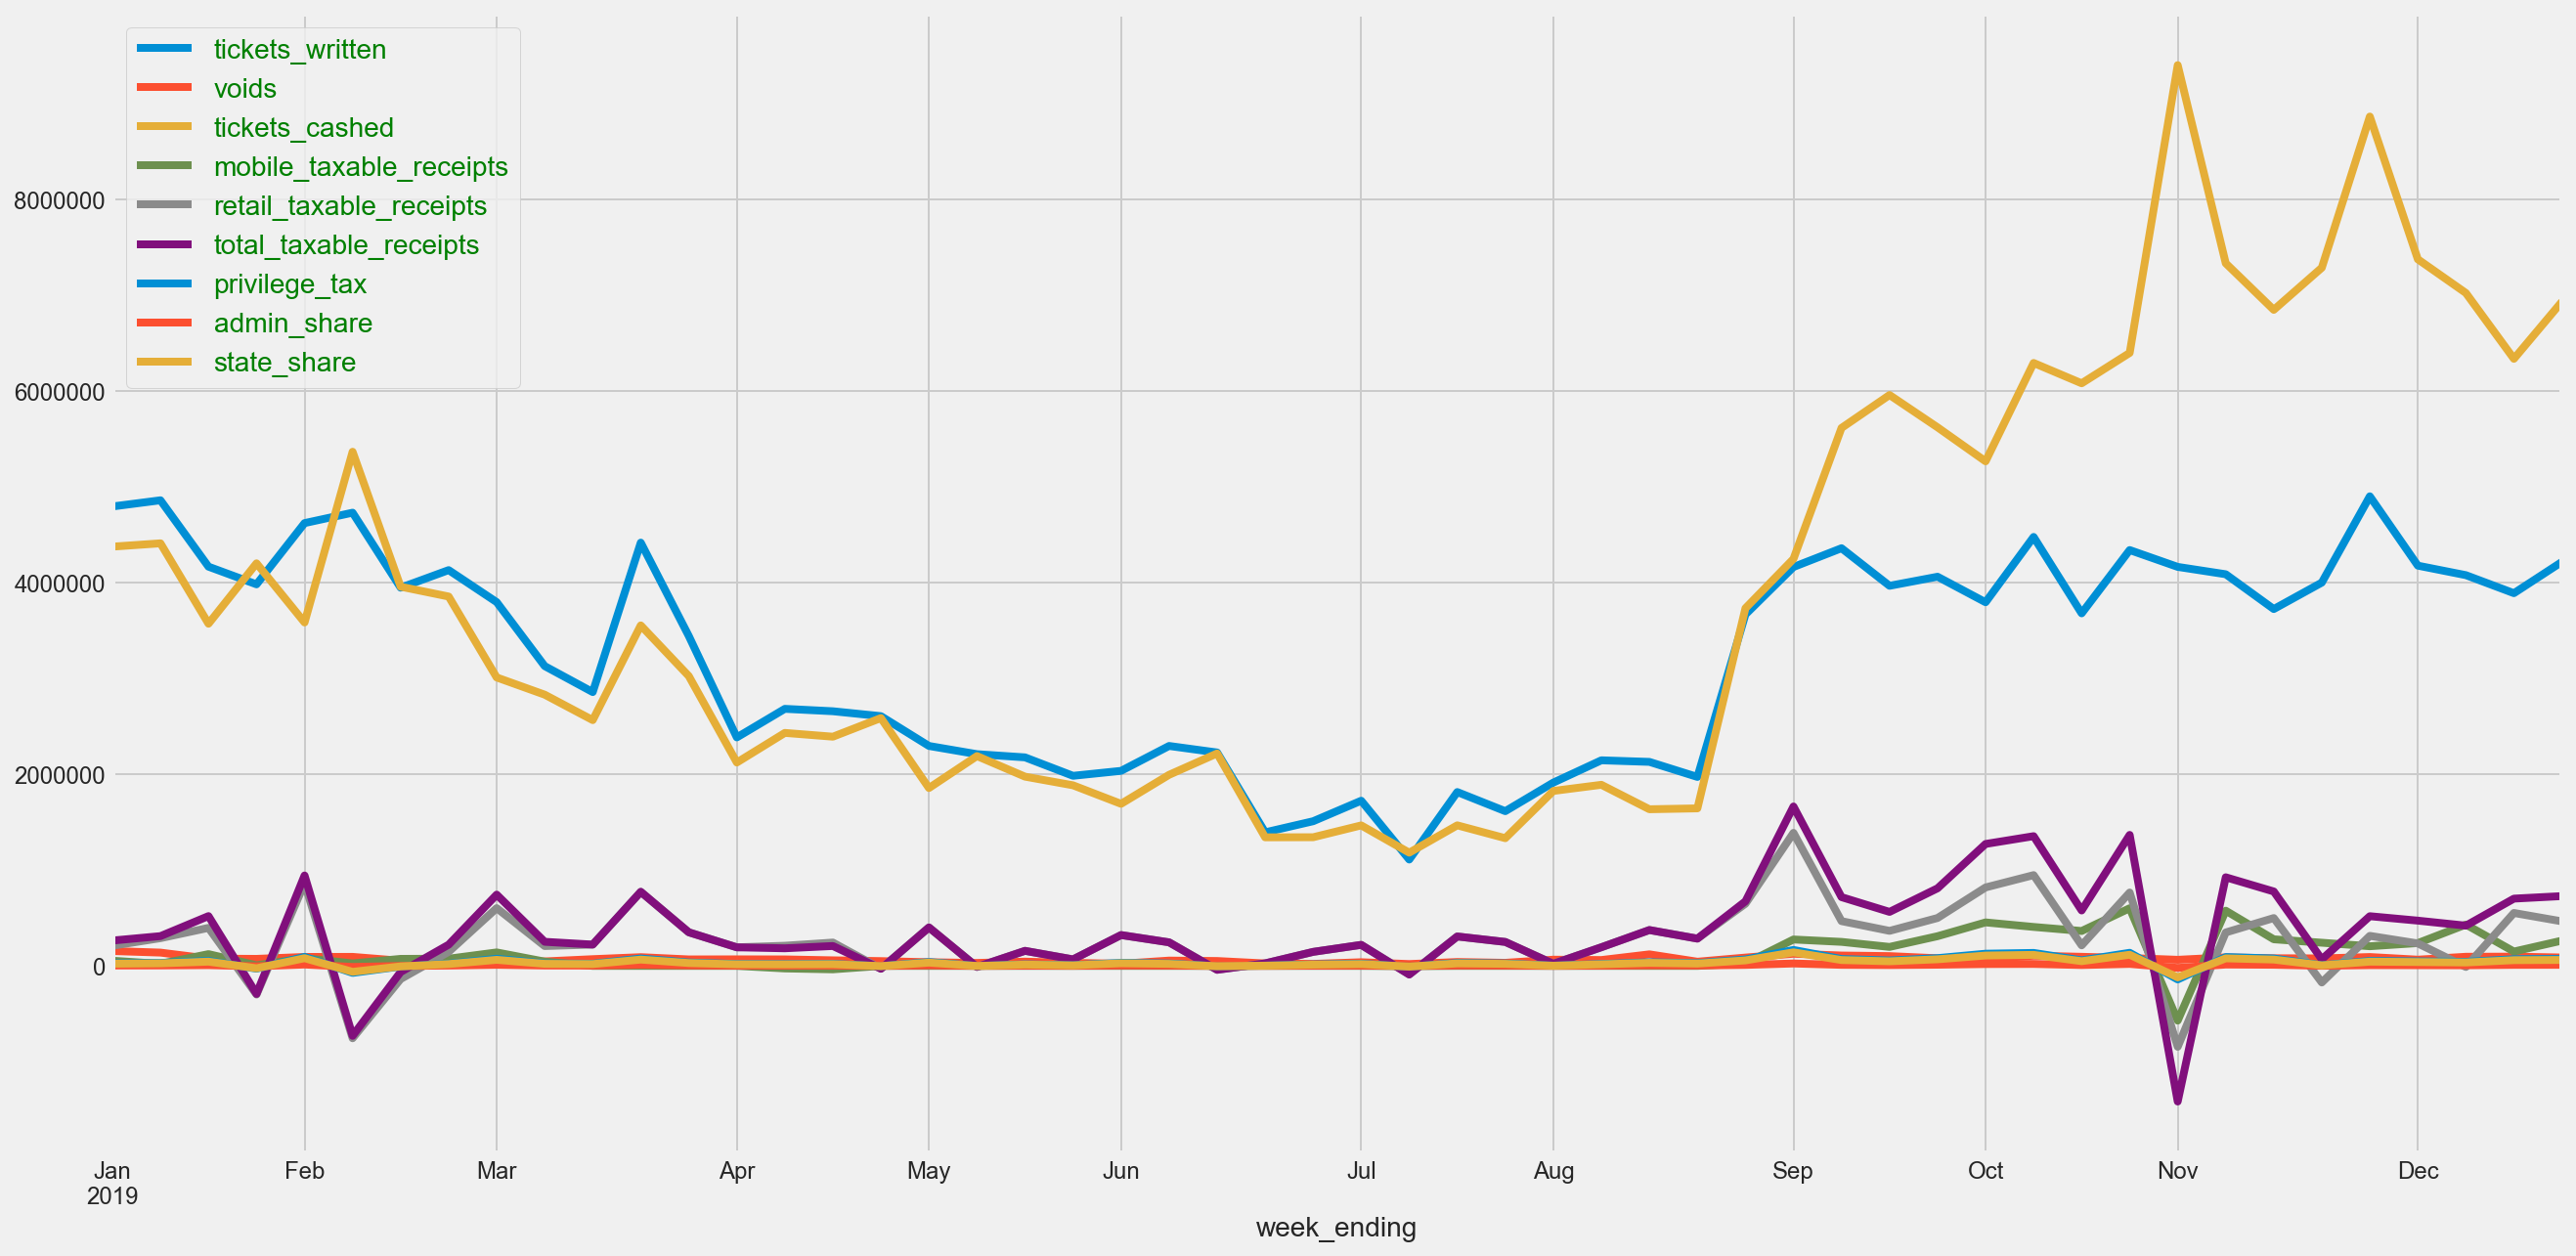

In [130]:
df.plot(figsize=(20, 10))
plt.show()

In [131]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [134]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

Using the “sm.tsa.seasonal_decompose” command from the pylab library we can decompose the time-series into three distinct components: trend, seasonality, and noise.

In [128]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

ValueError: x must have 2 complete cycles requires 104 observations. x only has 52 observation(s)